<a href="https://colab.research.google.com/github/dantecomedia/Video-Classifcation-using-Deep-Learning/blob/master/Shoplifting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
import random
import shutil
!pip install scikit-video
import numpy as np
from skvideo.io import FFmpegReader, ffprobe
from skvideo.utils import rgb2gray
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from __future__ import absolute_import

from keras import backend as K
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import layers
from keras.engine import InputSpec
from keras.utils import conv_utils
from keras.legacy.interfaces import conv3d_args_preprocessor, generate_legacy_interface
from keras.layers import Conv3D
from keras.backend.tensorflow_backend import _preprocess_padding, _preprocess_conv3d_input

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers.core import Dense
import tensorflow.keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dropout
from sklearn.metrics import classification_report

     |████████████████████████████████| 2.3MB 2.8MB/s 


Using TensorFlow backend.


In [ ]:
!cp "/content/gdrive/My Drive/Security Dataset/Trimmed Dataset-20200612T201236Z-001.zip" "/content/"
!unzip "/content/Trimmed Dataset-20200612T201236Z-001.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Trimmed Dataset/Burglary/Burglary011_x264_29.mp4  
  inflating: Trimmed Dataset/Arson/Arson034_x264_19.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary066_x264_14.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary071_x264_22.mp4  
  inflating: Trimmed Dataset/Arrest/Arrest036_x264_29.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary071_x264_13.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary037_x264_22.mp4  
  inflating: Trimmed Dataset/Arrest/Arrest017_x264_29.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary014_x264_29.mp4  
  inflating: Trimmed Dataset/Vandalism/Vandalism038_x264_30.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary069_x264_11.mp4  
  inflating: Trimmed Dataset/Stealing/Stealing018_x264_18.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary069_x264_2.mp4  
  inflating: Trimmed Dataset/Vandalism/Vandalism044_x264_9.mp4  
  inflating: Trimmed Dataset/Vandalism/Vandalism040_x264_3.mp4  


In [ ]:
#shutil.rmtree("/content/curated_dataset")

In [ ]:
!mkdir curated_dataset
!cp -r "/content/Trimmed Dataset/Shoplifting" "/content/curated_dataset"
!cp -r "/content/Trimmed Dataset/Normal" "/content/curated_dataset"

In [ ]:
import os
path="/content/curated_dataset/"
count=0
for i in os.listdir(path):
  count=0
  for j in os.listdir(path+str(i)):
    count=count+1
  print(i+":",count)

Shoplifting: 155
Normal: 1198


In [ ]:
1198-155

1043

In [ ]:
count=0
for i in os.listdir("/content/curated_dataset/Normal"):
  a=random.choice(os.listdir("/content/curated_dataset/Normal"))
  os.remove("/content/curated_dataset/Normal/"+str(a))
  count=count+1
  if count==1043:
    break

In [ ]:
raw_data=load_files(os.getcwd()+r'/curated_dataset/', shuffle=True)
files=raw_data['filenames']
targets=raw_data['target']

train_files, test_files, train_targets, test_targets=train_test_split(files, targets, test_size=1/3, random_state=191)

In [ ]:

valid_files = train_files[100:]
valid_targets = train_targets[100:]

# Remaining data will be used for training the model
train_files = train_files[:100]
train_targets = train_targets[:100]

# Generic details about the data
print('Total number of videos:', len(files))
print('\nNumber of videos in training data:', train_files.shape[0])
print('Number of videos in validation data:', valid_files.shape[0])
print('Number of videos in test data:', test_files.shape[0])

Total number of videos: 310

Number of videos in training data: 100
Number of videos in validation data: 106
Number of videos in test data: 104


In [ ]:
210-80

130

In [ ]:
print('The categorical labels are converted into integers.\nFollowing is the mapping - \n')
for label in zip(range(14), raw_data['target_names']):
    print(label)

The categorical labels are converted into integers.
Following is the mapping - 

(0, 'Normal')
(1, 'Shoplifting')


In [ ]:
for pair in zip(train_files[:5], train_targets[:5]):
    print(pair)

('/content/curated_dataset/Shoplifting/Shoplifting013_x264_5.mp4', 1)
('/content/curated_dataset/Shoplifting/Shoplifting009_x264_31.mp4', 1)
('/content/curated_dataset/Normal/Robbery050_x264_8.mp4', 0)
('/content/curated_dataset/Shoplifting/Shoplifting025_x264_13.mp4', 1)
('/content/curated_dataset/Normal/Robbery003_x264_4.mp4', 0)


In [ ]:
class Videos(object):

    def __init__(self, target_size=None, to_gray=True, max_frames=None,
                 extract_frames='middle', required_fps=None,
                 normalize_pixels=None):
        """
        Initializing the config variables

        Parameters:
            target_size (tuple): (New_Width, New_Height), Default 'None'
                A tuple denoting the target width and height of each frame in each of the video

            to_gray (boolean): Default 'True'
                If True, then each frame will be converted to gray scale. Otherwise, not.

            max_frames (int): Default 'None'
                The maximum number of frames to return for each video.
                Extra frames are removed based on the value of 'extract_frames'.

            extract_frames (str): {'first', 'middle', 'last'}, Default 'middle'
                'first': Extract the first 'N' frames

                'last': Extract the last 'N' frames

                'middle': Extract 'N' frames from the middle
                    Remove ((total_frames - max_frames) // 2) frames from the beginning as well as the end

            required_fps (int): Default 'None'
                Capture 'N' frame(s) per second from the video.

                Only the first 'N' frame(s) for each second in the video are captured.

            normalize_pixels (tuple/str): Default 'None'
                If 'None', the pixels will not be normalized.

                If a tuple - (New_min, New_max) is passed, Min-max Normalization will be used.

                If the value is 'z-score', then Z-score Normalization will be used.
                For each pixel p, z_score = (p - mean) / std
        """

        self.target_size = target_size
        self.to_gray = to_gray
        self.max_frames = max_frames
        self.extract_frames = extract_frames
        self.required_fps = required_fps
        self.normalize_pixels = normalize_pixels
        self.fps = None

    def read_videos(self, paths):
        """
        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read

        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (<No. of Videos>, <No. of frames>, <height>, <width>, <channels>)
        """

        list_of_videos = [
            self._read_video(path) for path in tqdm(paths)
        ]

        tensor = np.vstack(list_of_videos)

        if self.normalize_pixels != None:
            # Pixels are normalized for each video individually
            if (type(self.normalize_pixels) == tuple) and (len(self.normalize_pixels) == 2):
                base = self.normalize_pixels[0]
                r = self.normalize_pixels[1] - base
                min_ = np.min(tensor, axis=(1, 2, 3), keepdims=True)
                max_ = np.max(tensor, axis=(1, 2, 3), keepdims=True)
                return ((tensor.astype('float32') - min_) / (max_ - min_)) * r + base

            elif self.normalize_pixels == 'z-score':
                mean = np.mean(tensor, axis=(1, 2, 3), keepdims=True)
                std = np.std(tensor, axis=(1, 2, 3), keepdims=True)
                return (tensor.astype('float32') - mean) / std
            
            else:
                raise ValueError('Invalid value of \'normalize_pixels\'')

        return tensor

    def get_frame_count(self, paths):
        """
        Can be used to determine the value of `max_frames`

        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read

        Returns:
            dict (python dictionary)
                For each video, the total number of frames in that video is stored in the dictionary.
        """

        frame_count = {}
        for path in paths:
            cap = FFmpegReader(filename=path)
            frame_count[path] = cap.inputframenum
            cap.close()

        return frame_count

    def _read_video(self, path):
        """
        Parameters:
            path (str): Required
                Path of the video to be read

        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (1, <No. of frames>, <height>, <width>, <channels>)
        """

        cap = FFmpegReader(filename=path)
        list_of_frames = []
        self.fps = int(cap.inputfps)                  # Frame Rate

        for index, frame in enumerate(cap.nextFrame()):

            capture_frame = True
            if self.required_fps != None:
                is_valid = range(self.required_fps)
                capture_frame = (index % self.fps) in is_valid

            if capture_frame:

                if self.target_size is not None:
                    temp_image = image.array_to_img(frame)
                    frame = image.img_to_array(
                        temp_image.resize(
                            self.target_size,
                            Image.ANTIALIAS)).astype('uint8')

                # Shape of each frame -> (<height>, <width>, 3)
                list_of_frames.append(frame)

        temp_video = np.stack(list_of_frames)
        cap.close()

        if self.to_gray:
            temp_video = rgb2gray(temp_video)
                
        if self.max_frames is not None:
            temp_video = self._process_video(video=temp_video)

        return np.expand_dims(temp_video, axis=0)

    def _process_video(self, video):
        """
        Parameters:
            video (Numpy.ndarray):
                Shape = (<No. of frames>, <height>, <width>, <channels>)

                Video whose frames are to be extracted

        Returns:
            Numpy.ndarray
                A tensor (processed video) with shape (<`max_frames`>, <height>, <width>, <channels>)
        """

        total_frames = video.shape[0]
        if self.max_frames <= total_frames:

            if self.extract_frames == 'first':
                video = video[:self.max_frames]
            elif self.extract_frames == 'last':
                video = video[(total_frames - self.max_frames):]
            elif self.extract_frames == 'middle':
                # No. of frames to remove from the front
                front = ((total_frames - self.max_frames) // 2) + 1
                video = video[front:(front + self.max_frames)]
            else:
                raise ValueError('Invalid value of \'extract_frames\'')

        else:
            raise IndexError(
                'Required number of frames is greater than the total number of frames in the video')

        return video

100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Shape of the sample data: (1, 60, 240, 320, 3)


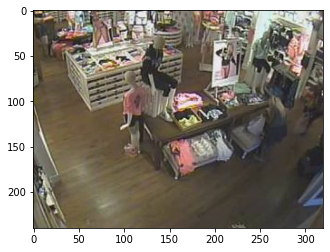

In [ ]:

# The path of a sample video in the training data
sample_files = train_files[:1]

# An object of the class 'Videos'
reader = Videos(target_size=None, 
                to_gray=False)

# Loading the sample videos, in their original format
sample = reader.read_videos(sample_files)
print('\nShape of the sample data:', sample.shape)

# Displaying a frame from the sample video
plt.imshow(sample[0][29])

In [ ]:
# An object of the class `Videos` to load the data in the required format
reader = Videos(target_size=(128, 128), 
                to_gray=True, 
                max_frames=29, 
                extract_frames='middle', 
                normalize_pixels=(0, 1))

In [ ]:
X_train = reader.read_videos(train_files)
y_train = to_categorical(train_targets, num_classes=2)
print('Shape of training data:', X_train.shape)
print('Shape of training labels:', y_train.shape)

100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


Shape of training data: (100, 29, 128, 128, 1)
Shape of training labels: (100, 2)


In [ ]:
X_valid = reader.read_videos(valid_files)
y_valid = to_categorical(valid_targets, num_classes=2)
print('Shape of validation data:', X_valid.shape)
print('Shape of validation labels:', y_valid.shape)

100%|██████████| 106/106 [00:46<00:00,  2.29it/s]


Shape of validation data: (106, 29, 128, 128, 1)
Shape of validation labels: (106, 2)


In [ ]:
X_test = reader.read_videos(test_files)
y_test = to_categorical(test_targets, num_classes=2)
print('Shape of testing data:', X_test.shape)
print('Shape of testing labels:', y_test.shape)

100%|██████████| 104/104 [00:46<00:00,  2.26it/s]


Shape of testing data: (104, 29, 128, 128, 1)
Shape of testing labels: (104, 2)


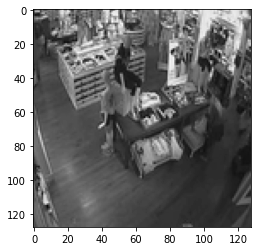

In [ ]:
# Displaying the first frame of the first processed video from the training data
plt.imshow(np.squeeze(X_train[0][0], axis=2), cmap='gray')

In [ ]:

def depthwise_conv3d_args_preprocessor(args, kwargs):
    converted = []

    if 'init' in kwargs:
        init = kwargs.pop('init')
        kwargs['depthwise_initializer'] = init
        converted.append(('init', 'depthwise_initializer'))

    args, kwargs, _converted = conv3d_args_preprocessor(args, kwargs)
    return args, kwargs, converted + _converted

    legacy_depthwise_conv3d_support = generate_legacy_interface(
    allowed_positional_args=['filters', 'kernel_size'],
    conversions=[('nb_filter', 'filters'),
                 ('subsample', 'strides'),
                 ('border_mode', 'padding'),
                 ('dim_ordering', 'data_format'),
                 ('b_regularizer', 'bias_regularizer'),
                 ('b_constraint', 'bias_constraint'),
                 ('bias', 'use_bias')],
    value_conversions={'dim_ordering': {'tf': 'channels_last',
                                        'th': 'channels_first',
                                        'default': None}},
    preprocessor=depthwise_conv3d_args_preprocessor)


class DepthwiseConv3D(Conv3D):
    """Depthwise 3D convolution.
    Depth-wise part of separable convolutions consist in performing
    just the first step/operation
    (which acts on each input channel separately).
    It does not perform the pointwise convolution (second step).
    The `depth_multiplier` argument controls how many
    output channels are generated per input channel in the depthwise step.
    # Arguments
        kernel_size: An integer or tuple/list of 3 integers, specifying the
            depth, width and height of the 3D convolution window.
            Can be a single integer to specify the same value for
            all spatial dimensions.
        strides: An integer or tuple/list of 3 integers,
            specifying the strides of the convolution along the depth, width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
        padding: one of `"valid"` or `"same"` (case-insensitive).
        depth_multiplier: The number of depthwise convolution output channels
            for each input channel.
            The total number of depthwise convolution output
            channels will be equal to `filterss_in * depth_multiplier`.
        groups: The depth size of the convolution (as a variant of the original Depthwise conv)
        data_format: A string,
            one of `channels_last` (default) or `channels_first`.
            The ordering of the dimensions in the inputs.
            `channels_last` corresponds to inputs with shape
            `(batch, height, width, channels)` while `channels_first`
            corresponds to inputs with shape
            `(batch, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you don't specify anything, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        depthwise_initializer: Initializer for the depthwise kernel matrix
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        depthwise_regularizer: Regularizer function applied to
            the depthwise kernel matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        dialation_rate: List of ints.
                        Defines the dilation factor for each dimension in the
                        input. Defaults to (1,1,1)
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        depthwise_constraint: Constraint function applied to
            the depthwise kernel matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
    # Input shape
        5D tensor with shape:
        `(batch, depth, channels, rows, cols)` if data_format='channels_first'
        or 5D tensor with shape:
        `(batch, depth, rows, cols, channels)` if data_format='channels_last'.
    # Output shape
        5D tensor with shape:
        `(batch, filters * depth, new_depth, new_rows, new_cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(batch, new_depth, new_rows, new_cols, filters * depth)` if data_format='channels_last'.
        `rows` and `cols` values might have changed due to padding.
    """

    #@legacy_depthwise_conv3d_support
    def __init__(self,
                 kernel_size,
                 strides=(1, 1, 1),
                 padding='valid',
                 depth_multiplier=1,
                 groups=None,
                 data_format=None,
                 activation=None,
                 use_bias=True,
                 depthwise_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 dilation_rate = (1, 1, 1),
                 depthwise_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 depthwise_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(DepthwiseConv3D, self).__init__(
            filters=None,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            activation=activation,
            use_bias=use_bias,
            bias_regularizer=bias_regularizer,
            dilation_rate=dilation_rate,
            activity_regularizer=activity_regularizer,
            bias_constraint=bias_constraint,
            **kwargs)
        self.depth_multiplier = depth_multiplier
        self.groups = groups
        self.depthwise_initializer = initializers.get(depthwise_initializer)
        self.depthwise_regularizer = regularizers.get(depthwise_regularizer)
        self.depthwise_constraint = constraints.get(depthwise_constraint)
        self.bias_initializer = initializers.get(bias_initializer)
        self.dilation_rate = dilation_rate
        self._padding = _preprocess_padding(self.padding)
        self._strides = (1,) + self.strides + (1,)
        self._data_format = "NDHWC"
        self.input_dim = None

    def build(self, input_shape):
        if len(input_shape) < 5:
            raise ValueError('Inputs to `DepthwiseConv3D` should have rank 5. '
                             'Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs to '
                             '`DepthwiseConv3D` '
                             'should be defined. Found `None`.')
        self.input_dim = int(input_shape[channel_axis])

        if self.groups is None:
            self.groups = self.input_dim

        if self.groups > self.input_dim:
            raise ValueError('The number of groups cannot exceed the number of channels')

        if self.input_dim % self.groups != 0:
            raise ValueError('Warning! The channels dimension is not divisible by the group size chosen')

        depthwise_kernel_shape = (self.kernel_size[0],
                                  self.kernel_size[1],
                                  self.kernel_size[2],
                                  self.input_dim,
                                  self.depth_multiplier)

        self.depthwise_kernel = self.add_weight(
            shape=depthwise_kernel_shape,
            initializer=self.depthwise_initializer,
            name='depthwise_kernel',
            regularizer=self.depthwise_regularizer,
            constraint=self.depthwise_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.groups * self.depth_multiplier,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=5, axes={channel_axis: self.input_dim})
        self.built = True

    def call(self, inputs, training=None):
        inputs = _preprocess_conv3d_input(inputs, self.data_format)

        if self.data_format == 'channels_last':
            dilation = (1,) + self.dilation_rate + (1,)
        else:
            dilation = self.dilation_rate + (1,) + (1,)

        if self._data_format == 'NCDHW':
            outputs = tf.concat(
                [tf.nn.conv3d(inputs[0][:, i:i+self.input_dim//self.groups, :, :, :], self.depthwise_kernel[:, :, :, i:i+self.input_dim//self.groups, :],
                    strides=self._strides,
                    padding=self._padding,
                    dilations=dilation,
                    data_format=self._data_format) for i in range(0, self.input_dim, self.input_dim//self.groups)], axis=1)

        else:
            outputs = tf.concat(
                [tf.nn.conv3d(inputs[0][:, :, :, :, i:i+self.input_dim//self.groups], self.depthwise_kernel[:, :, :, i:i+self.input_dim//self.groups, :],
                    strides=self._strides,
                    padding=self._padding,
                    dilations=dilation,
                    data_format=self._data_format) for i in range(0, self.input_dim, self.input_dim//self.groups)], axis=-1)

        if self.bias is not None:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)

        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            depth = input_shape[2]
            rows = input_shape[3]
            cols = input_shape[4]
            out_filters = self.groups * self.depth_multiplier
        elif self.data_format == 'channels_last':
            depth = input_shape[1]
            rows = input_shape[2]
            cols = input_shape[3]
            out_filters = self.groups * self.depth_multiplier

        depth = conv_utils.conv_output_length(depth, self.kernel_size[0],
                                             self.padding,
                                             self.strides[0])

        rows = conv_utils.conv_output_length(rows, self.kernel_size[1],
                                             self.padding,
                                             self.strides[1])

        cols = conv_utils.conv_output_length(cols, self.kernel_size[2],
                                             self.padding,
                                             self.strides[2])

        if self.data_format == 'channels_first':
            return (input_shape[0], out_filters, depth, rows, cols)

        elif self.data_format == 'channels_last':
            return (input_shape[0], depth, rows, cols, out_filters)

    def get_config(self):
        config = super(DepthwiseConv3D, self).get_config()
        config.pop('filters')
        config.pop('kernel_initializer')
        config.pop('kernel_regularizer')
        config.pop('kernel_constraint')
        config['depth_multiplier'] = self.depth_multiplier
        config['depthwise_initializer'] = initializers.serialize(self.depthwise_initializer)
        config['depthwise_regularizer'] = regularizers.serialize(self.depthwise_regularizer)
        config['depthwise_constraint'] = constraints.serialize(self.depthwise_constraint)
        return config

DepthwiseConvolution3D = DepthwiseConv3D

In [ ]:
model = Sequential()

# Adding Alternate convolutional and pooling layers
model.add(Conv3D(filters=16, kernel_size=(10, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', 
                 input_shape=X_train.shape[1:]))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model.add(Conv3D(filters=64, kernel_size=(5, 3, 3), strides=(3, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model.add(Conv3D(filters=256, kernel_size=(5, 3, 3), strides=(3, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

# A global average pooling layer to get a 1-d vector
# The vector will have a depth (same as number of elements in the vector) of 256
model.add(GlobalAveragePooling3D())

# The Global average pooling layer is followed by a fully-connected neural network, with one hidden and one output layer

# Hidden Layer
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 29, 128, 128, 16)  1456      
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 29, 64, 64, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 9, 62, 62, 64)     46144     
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 9, 31, 31, 64)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 2, 29, 29, 256)    737536    
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 2, 15, 15, 256)    0         
_________________________________________________________________
global_average_pooling3d_3 ( (None, 256)              

In [ ]:
from keras.callbacks import ModelCheckpoint

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model_Shoplifting_1.weights.best.hdf5', save_best_only=True, verbose=1)

# Training the model for 80 epochs
history = model.fit(X_train, y_train, batch_size=16, epochs=80, 
                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint])

Train on 100 samples, validate on 106 samples
Epoch 1/80
 - 3s - loss: 1.0138 - accuracy: 0.4400 - val_loss: 0.6920 - val_accuracy: 0.5377

Epoch 00001: val_loss improved from inf to 0.69201, saving model to Model_Shoplifting_1.weights.best.hdf5
Epoch 2/80
 - 2s - loss: 0.6931 - accuracy: 0.4800 - val_loss: 0.6929 - val_accuracy: 0.5377

Epoch 00002: val_loss did not improve from 0.69201
Epoch 3/80
 - 2s - loss: 0.6933 - accuracy: 0.4800 - val_loss: 0.6931 - val_accuracy: 0.5377

Epoch 00003: val_loss did not improve from 0.69201
Epoch 4/80
 - 2s - loss: 0.6932 - accuracy: 0.4700 - val_loss: 0.6932 - val_accuracy: 0.4623

Epoch 00004: val_loss did not improve from 0.69201
Epoch 5/80
 - 2s - loss: 0.6931 - accuracy: 0.5200 - val_loss: 0.6934 - val_accuracy: 0.4623

Epoch 00005: val_loss did not improve from 0.69201
Epoch 6/80
 - 2s - loss: 0.6933 - accuracy: 0.5200 - val_loss: 0.6937 - val_accuracy: 0.4623

Epoch 00006: val_loss did not improve from 0.69201
Epoch 7/80
 - 2s - loss: 0.69

In [ ]:
model.load_weights('/content/Model_Shoplifting_1.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=16, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 71.15%


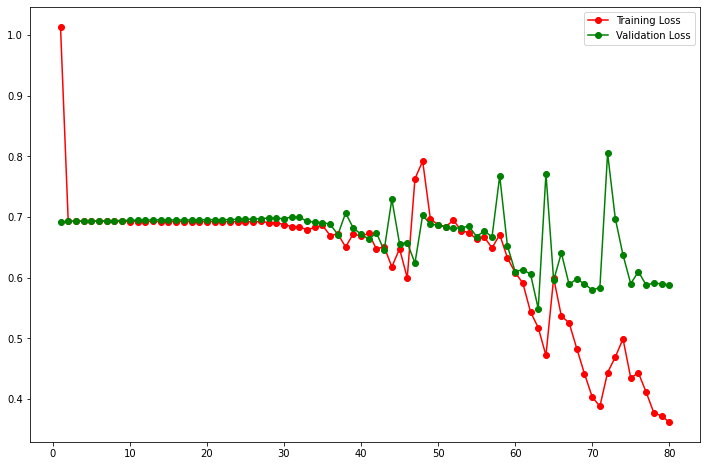

In [ ]:
# Making the plot larger
plt.figure(figsize=(12, 8))

loss = history.history['loss']                          # Loss on the training data
val_loss = history.history['val_loss']                  # Loss on the validation data
epochs = range(1, 81)

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.legend()

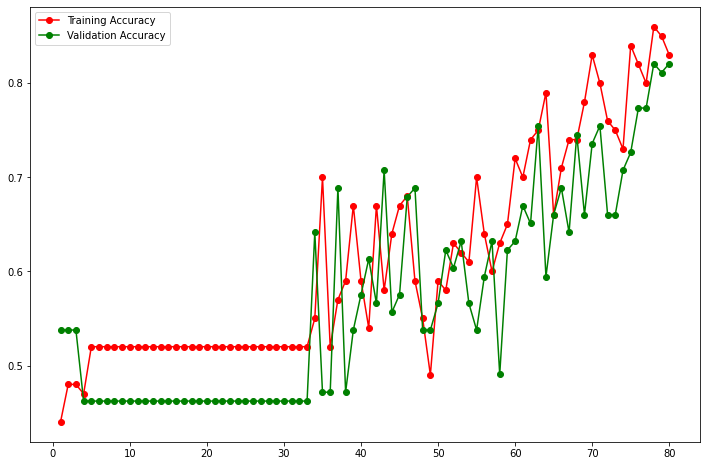

In [ ]:

# Making the plot larger
plt.figure(figsize=(12, 8))

acc = history.history['accuracy']                          # Loss on the training data
val_acc = history.history['val_accuracy']                  # Loss on the validation data
epochs = range(1, 81)

plt.plot(epochs, acc, 'ro-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'go-', label = 'Validation Accuracy')
plt.legend()

In [ ]:
y_pred=model.predict(X_test)
y_pred=y_pred>0.90
target_names = ['class Normal', 'class Shoplifting']
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     class Normal       1.00      0.02      0.04        50
class Shoplifting       1.00      0.17      0.29        54

        micro avg       1.00      0.10      0.18       104
        macro avg       1.00      0.09      0.16       104
     weighted avg       1.00      0.10      0.17       104
      samples avg       0.10      0.10      0.10       104



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_d = Sequential()

# Adding Alternate convolutional and pooling layers
model_d.add(DepthwiseConv3D( kernel_size=(10, 3, 3),depth_multiplier=2, strides=(1, 1, 1), padding='same', activation='relu', 
                 input_shape=X_train.shape[1:]))
model_d.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model_d.add(DepthwiseConv3D( depth_multiplier=4,kernel_size=(5, 3, 3), strides=(3, 1, 1), padding='valid', activation='relu'))
model_d.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model_d.add(DepthwiseConv3D(depth_multiplier=8, kernel_size=(5, 3, 3), strides=(3, 1, 1), padding='valid', activation='relu'))
model_d.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

# A global average pooling layer to get a 1-d vector
# The vector will have a depth (same as number of elements in the vector) of 256
model_d.add(GlobalAveragePooling3D())

# The Global average pooling layer is followed by a fully-connected neural network, with one hidden and one output layer

# Hidden Layer
model_d.add(Dense(32, activation='relu'))

# Output layer
model_d.add(Dense(2, activation='softmax'))

model_d.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv3d_4 (Depthwis (None, 29, 128, 128, 2)   182       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 29, 64, 64, 2)     0         
_________________________________________________________________
depthwise_conv3d_5 (Depthwis (None, 9, 62, 62, 8)      368       
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 9, 31, 31, 8)      0         
_________________________________________________________________
depthwise_conv3d_6 (Depthwis (None, 2, 29, 29, 64)     2944      
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 2, 15, 15, 64)     0         
_________________________________________________________________
global_average_pooling3d_4 ( (None, 64)               

In [ ]:
from keras.callbacks import ModelCheckpoint

# Compiling the model
model_d.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model_depthwise_1_Shoplifting.weights.best.hdf5', save_best_only=True, verbose=1)

# Training the model for 40 epochs
history = model_d.fit(X_train, y_train, batch_size=16, epochs=200, 
                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint])

Train on 100 samples, validate on 106 samples
Epoch 1/200
 - 2s - loss: 0.6932 - accuracy: 0.5200 - val_loss: 0.6936 - val_accuracy: 0.4623

Epoch 00001: val_loss improved from inf to 0.69358, saving model to Model_depthwise_1_Shoplifting.weights.best.hdf5
Epoch 2/200
 - 1s - loss: 0.6917 - accuracy: 0.5200 - val_loss: 0.6947 - val_accuracy: 0.4623

Epoch 00002: val_loss did not improve from 0.69358
Epoch 3/200
 - 1s - loss: 0.6900 - accuracy: 0.5200 - val_loss: 0.6983 - val_accuracy: 0.4623

Epoch 00003: val_loss did not improve from 0.69358
Epoch 4/200
 - 1s - loss: 0.6915 - accuracy: 0.5200 - val_loss: 0.6992 - val_accuracy: 0.4623

Epoch 00004: val_loss did not improve from 0.69358
Epoch 5/200
 - 1s - loss: 0.6890 - accuracy: 0.5200 - val_loss: 0.6985 - val_accuracy: 0.4623

Epoch 00005: val_loss did not improve from 0.69358
Epoch 6/200
 - 1s - loss: 0.6883 - accuracy: 0.5200 - val_loss: 0.6988 - val_accuracy: 0.4623

Epoch 00006: val_loss did not improve from 0.69358
Epoch 7/200
 

Accuracy on test data: 78.85%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

     class Normal       0.94      0.60      0.73        50
class Shoplifting       0.88      0.43      0.57        54

        micro avg       0.91      0.51      0.65       104
        macro avg       0.91      0.51      0.65       104
     weighted avg       0.91      0.51      0.65       104
      samples avg       0.51      0.51      0.51       104



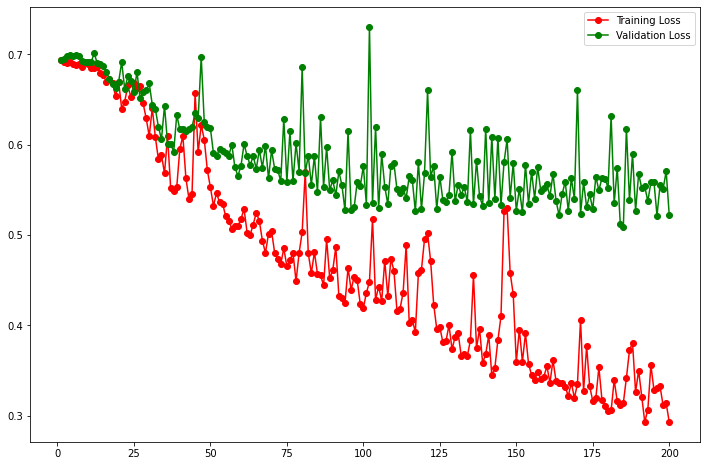

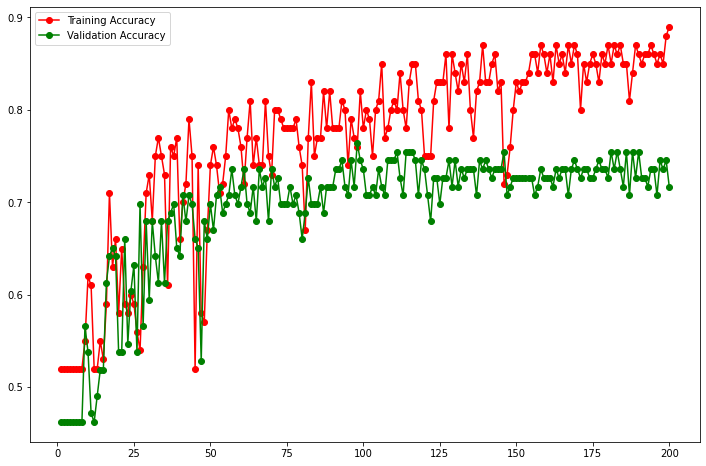

In [ ]:
model_d.load_weights('/content/Model_depthwise_1_Shoplifting.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model_d.evaluate(X_test, y_test, batch_size=16, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

# Making the plot larger
plt.figure(figsize=(12, 8))

loss = history.history['loss']                          # Loss on the training data
val_loss = history.history['val_loss']                  # Loss on the validation data
epochs = range(1, 201)

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.legend()


# Making the plot larger
plt.figure(figsize=(12, 8))

acc = history.history['accuracy']                          # Loss on the training data
val_acc = history.history['val_accuracy']                  # Loss on the validation data
epochs = range(1, 201)

plt.plot(epochs, acc, 'ro-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'go-', label = 'Validation Accuracy')
plt.legend()


y_pred=model_d.predict(X_test)
y_pred=y_pred>0.80
target_names = ['class Normal', 'class Shoplifting']
print(classification_report(y_test, y_pred, target_names=target_names))

In [ ]:

!mkdir "/content/gdrive/My Drive/Security Dataset/Shoplifting"
!cp -r "/content/curated_dataset" "/content/gdrive/My Drive/Security Dataset/Shoplifting"

In [ ]:
!mkdir "/content/gdrive/My Drive/Security Dataset/Shoplifting/weights"
!cp -r "/content/Model_depthwise_1_Shoplifting.weights.best.hdf5" "/content/gdrive/My Drive/Security Dataset/Shoplifting/weights"
#!cp -r "/content/Model_depthwise_2_arson.weights.best.hdf5" "/content/gdrive/My Drive/Security Dataset/Assault/weights"
!cp -r "/content/Model_Shoplifting_1.weights.best.hdf5" "/content/gdrive/My Drive/Security Dataset/Shoplifting/weights"
#!cp -r "/content/Model_arson_2_larger_parameters.weights.best.hdf5" "/content/gdrive/My Drive/Security Dataset/Assault/weights"